<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Multivariate time series

---

So far we have looked at univariate time series, the time dependence of a single variable. In multivariate time series one considers how several variables change together with time. Practical use cases are portfolios of stocks or price indices.

If we want to preserve stationarity like in the univariate case, we require constant mean for all variables, but additionally constancy of the covariance matrix of all variables over time and that there are no correlations between the variables across different times.

Then we can build ARIMA models like before:


$$y_t = \mu + A_1 y_{t-1} + \dots + A_p y_{t-p} + \epsilon_t +
    M_1 \epsilon_{t-1} + \dots M_q \epsilon_{t-q}$$

where $\epsilon_t \sim N(0, \Omega)$. $y_t$ and $\epsilon_t$ are vectors with as many entries as we have variables, and $A_i$ and $M_i$ are quadratic matrices with as many rows and columns as variables. 

In the multivariate case we speak of VARMA models. They are implemented in the VARMAX class in Statsmodels.

In [1]:
# this will filter out a lot of future warnings from statsmodels
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from dateutil.relativedelta import relativedelta

sns.set(font_scale=1.5)
plt.style.use('fivethirtyeight')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [3]:
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf, pacf, ccf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

#### Let's look at an example which combines time series for consumer price indices and industrial production rates.

In [4]:
IP = pd.read_csv('datasets/IP.dat.csv')
IP.columns = ['date','IP']
IP['date'] = pd.to_datetime(IP.date)
IP.set_index('date',inplace=True)
IP.head()

,IP
date,
1919-01-28,7.628
1919-02-28,7.291
1919-03-28,7.080
1919-04-28,7.206
1919-05-28,7.249


In [5]:
CPI = pd.read_csv('datasets/CPI.dat.csv')
CPI.columns = ['date','CPI']
CPI['date'] = pd.to_datetime(CPI.date)
CPI.set_index('date',inplace=True)
CPI.head()

,CPI
date,
1913-01-31,9.8
1913-02-28,9.8
1913-03-31,9.8
1913-04-30,9.8
1913-05-31,9.7


In [6]:
df = CPI.merge(IP,left_index=True,right_index=True,how='inner')

In [7]:
df.head()

,CPI,IP
date,,
1919-02-28,16.2,7.291
1921-02-28,18.4,6.111
1922-02-28,16.9,7.080
1923-02-28,16.8,9.229
1925-02-28,17.2,9.609


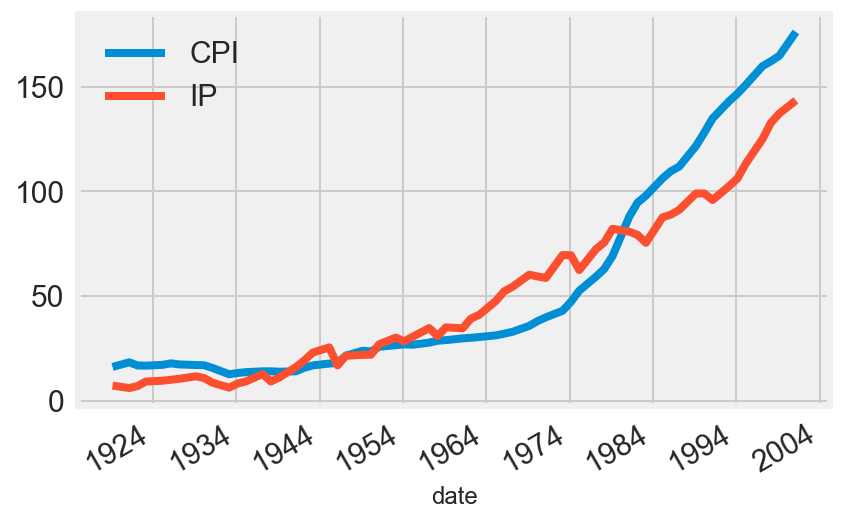

In [8]:
df.plot();

#### We use a log transform and differencing to make the time series stationary.

In [9]:
df = df.apply(np.log)

In [10]:
df_1 = df.diff(1)

#### Let's visualise the time series.

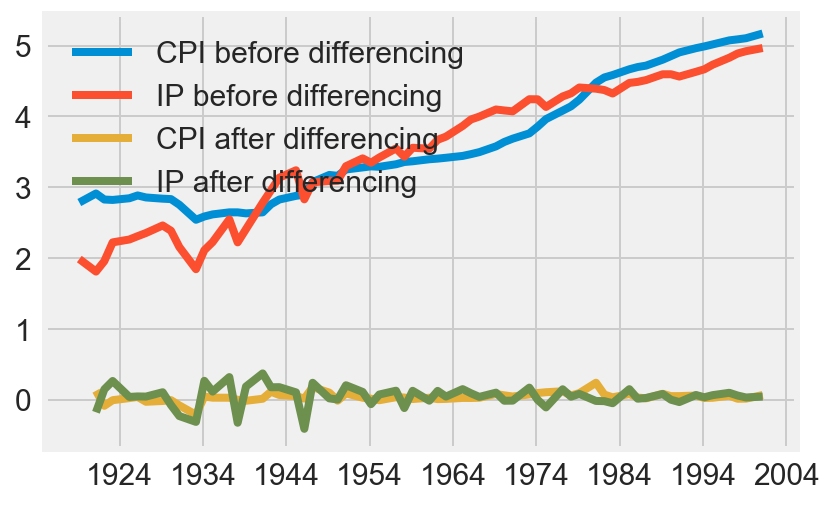

In [11]:
plt.plot(df)
plt.plot(df_1)
plt.legend([df.columns[0]+' before differencing',df.columns[1]+' before differencing',df.columns[0]+' after differencing',df.columns[1]+' after differencing'],loc='upper left')
plt.show()

#### We can look at the autocorrelations of each variable.

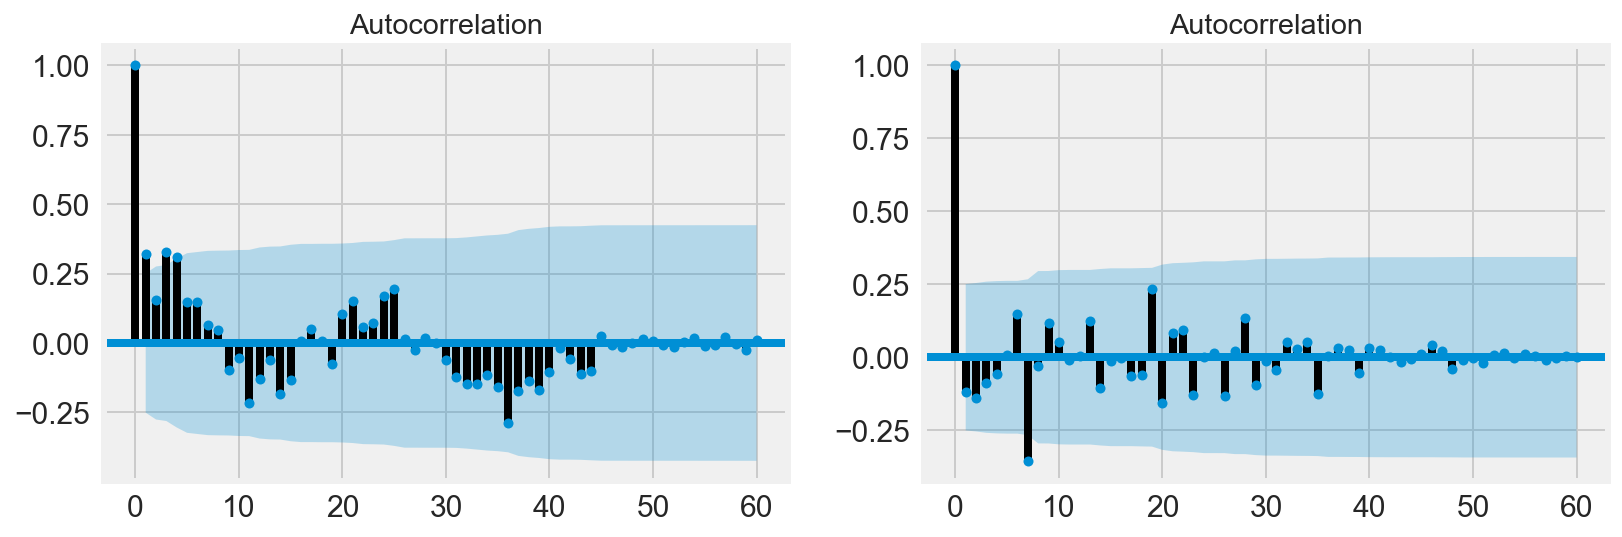

In [12]:
fig, ax = plt.subplots(ncols=2,figsize=(12,4))
plot_acf(df_1.CPI[1:], ax=ax[0])
plot_acf(df_1.IP[1:], ax=ax[1])
plt.show()

#### We can look at the values of the cross correlation matrix at every lag.

**Note:** Cross correlations are not symmetric.

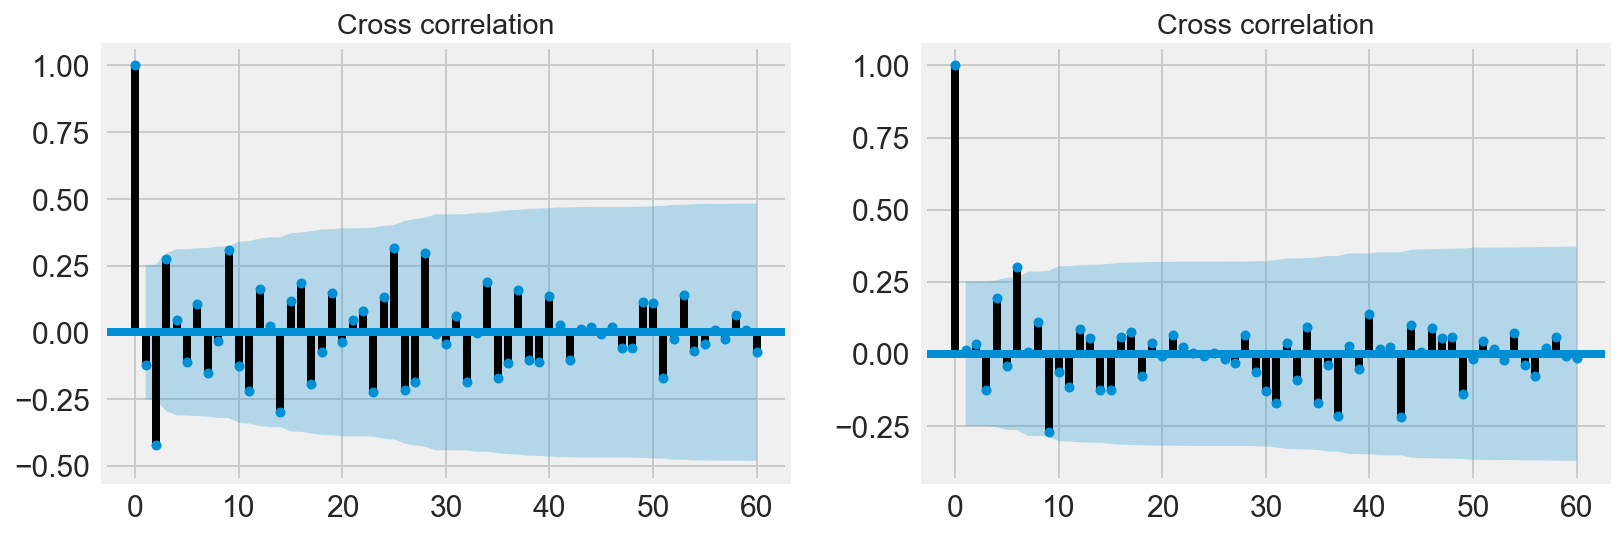

In [13]:
fig, ax = plt.subplots(ncols=2,figsize=(12,4))
plot_acf(ccf(df_1.CPI[1:], df_1.IP[1:]), ax=ax[0])
ax[0].set_title('Cross correlation')
plot_acf(ccf(df_1.IP[1:], df_1.CPI[1:]), ax=ax[1])
ax[1].set_title('Cross correlation')
plt.show()

#### Fitting a model is again very simple, we just need to indicate the order for $p$ and $q$. Now we get coefficient matrices for each AR term and each MA term.

In [14]:
model = sm.tsa.VARMAX(df_1[1:], order=(1,1), trend='nc')
results = model.fit(maxiter=1000, disp=False)
results.summary()

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/varmax.py:153: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)


Dep. Variable:,"['CPI', 'IP']",No. Observations:,61
Model:,"VARMA(1,1)",Log Likelihood,126.175
Date:,"Wed, 22 Aug 2018",AIC,-230.350
Time:,21:54:14,BIC,-207.131
Sample:,02-28-1921,HQIC,-221.250
,- 02-28-2001,,
Covariance Type:,opg,,
Ljung-Box (Q):,"25.58, 46.75",Jarque-Bera (JB):,"6.33, 8.79"
Prob(Q):,"0.96, 0.21",Prob(JB):,"0.04, 0.01"
Heteroskedasticity (H):,"0.38, 0.12",Skew:,"0.42, -0.65"
Prob(H) (two-sided):,"0.03, 0.00",Kurtosis:,"4.34, 4.33"


#### We can extract the AR and MA coefficient matrices.

In [15]:
print(results.coefficient_matrices_var)

[[[ 0.74233257  0.42851582]
  [ 0.76563324 -0.34125215]]]


In [16]:
print(results.coefficient_matrices_vma)

[[[-0.58805398 -0.39155036]
  [-1.39517177  0.42718392]]]


#### Let's search for the best AR model according to AIC and BIC.

In [17]:
for i in range(1,6):
    model = sm.tsa.VARMAX(df_1, order=(i,0))
    results = model.fit(maxiter=1000, disp=False)
    print(i, results.aic, results.bic)

1 -232.04238342782264 -212.89817396241682
2 -225.20190585424027 -197.5491588486541
3 -227.84816154184642 -191.68687699607986
4 -223.9847676254904 -179.3149455395435
5 -221.25202837238544 -168.07366874625814


In [18]:
model = sm.tsa.VARMAX(df_1, order=(1,0))
results = model.fit(maxiter=1000, disp=False)

In [19]:
coeffs_ar = results.coefficient_matrices_var[0]
print(coeffs_ar)

[[ 0.32681406  0.02567423]
 [-0.37948597 -0.0872186 ]]


#### Let's look at one particular model.

In [20]:
model = sm.tsa.VARMAX(df_1[1:], order=(1,0))
results = model.fit(maxiter=1000, disp=False)

In [21]:
results.summary()

Dep. Variable:,"['CPI', 'IP']",No. Observations:,61
Model:,VAR(1),Log Likelihood,125.021
,+ intercept,AIC,-232.042
Date:,"Wed, 22 Aug 2018",BIC,-213.045
Time:,21:54:21,HQIC,-224.597
Sample:,02-28-1921,,
,- 02-28-2001,,
Covariance Type:,opg,,
Ljung-Box (Q):,"34.27, 35.49",Jarque-Bera (JB):,"8.89, 28.48"
Prob(Q):,"0.73, 0.67",Prob(JB):,"0.01, 0.00"
Heteroskedasticity (H):,"0.43, 0.07",Skew:,"0.29, -1.14"


#### We can plot the residuals and obtain forecasts simimlar to the univariate case.

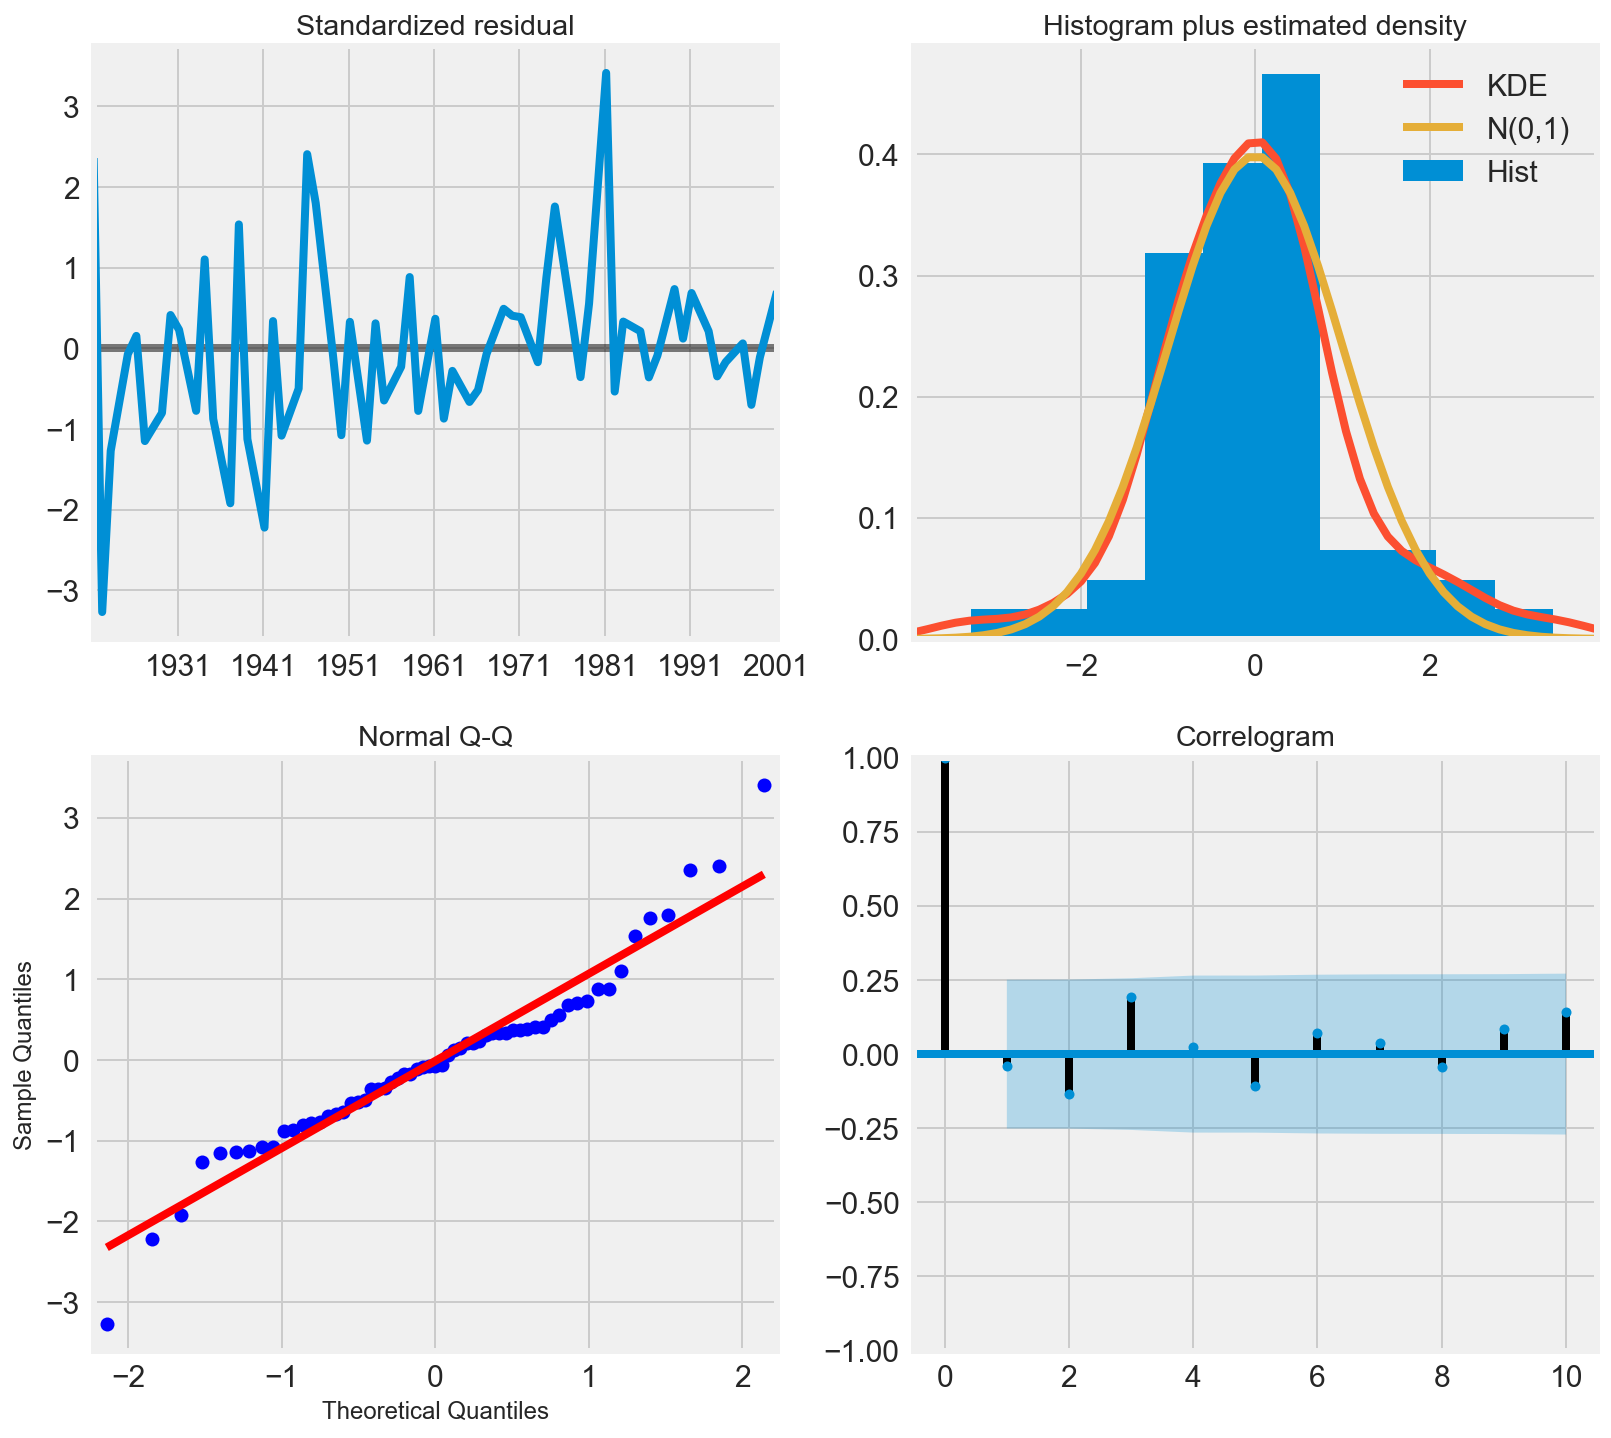

In [22]:
results.plot_diagnostics(0,figsize=(12,12))
plt.show()

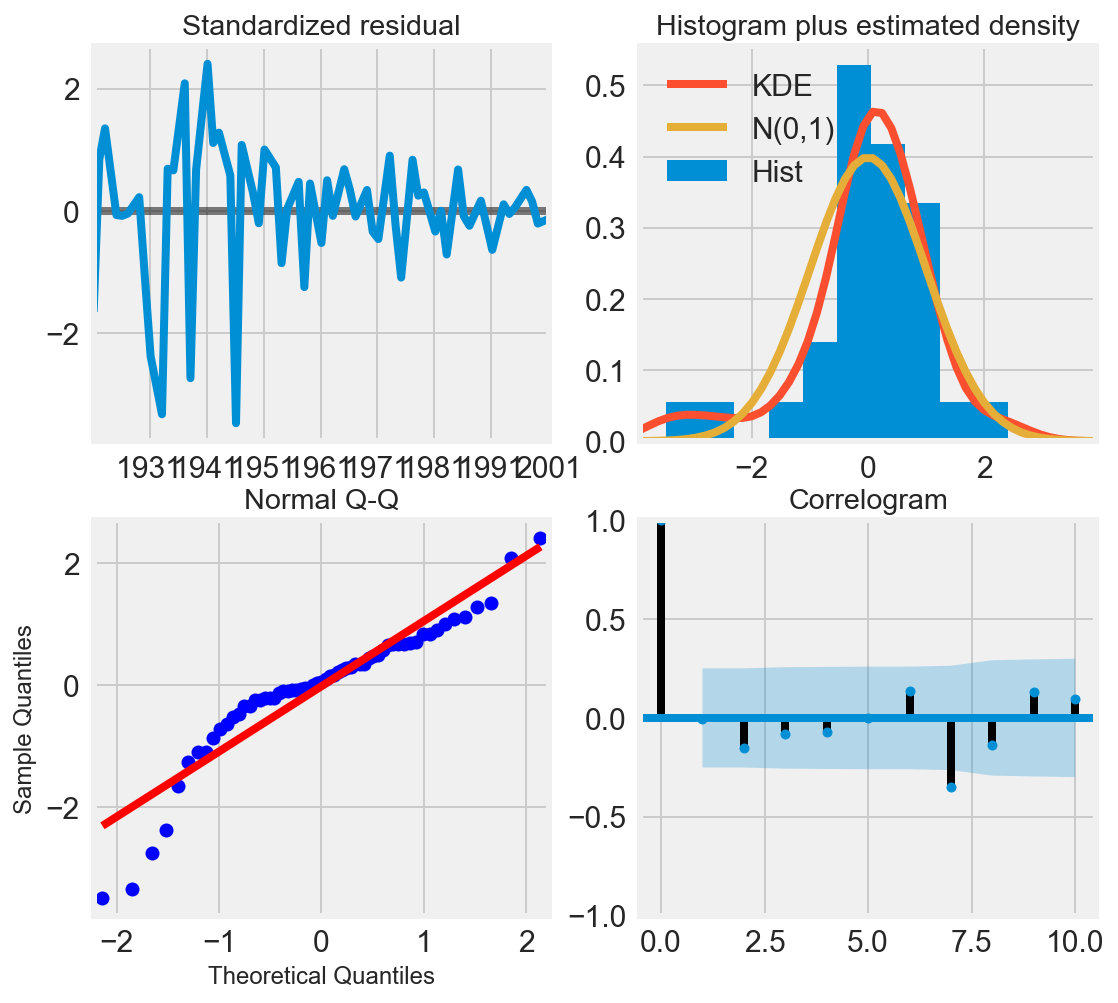

In [23]:
results.plot_diagnostics(1,figsize=(8,8))
plt.show()

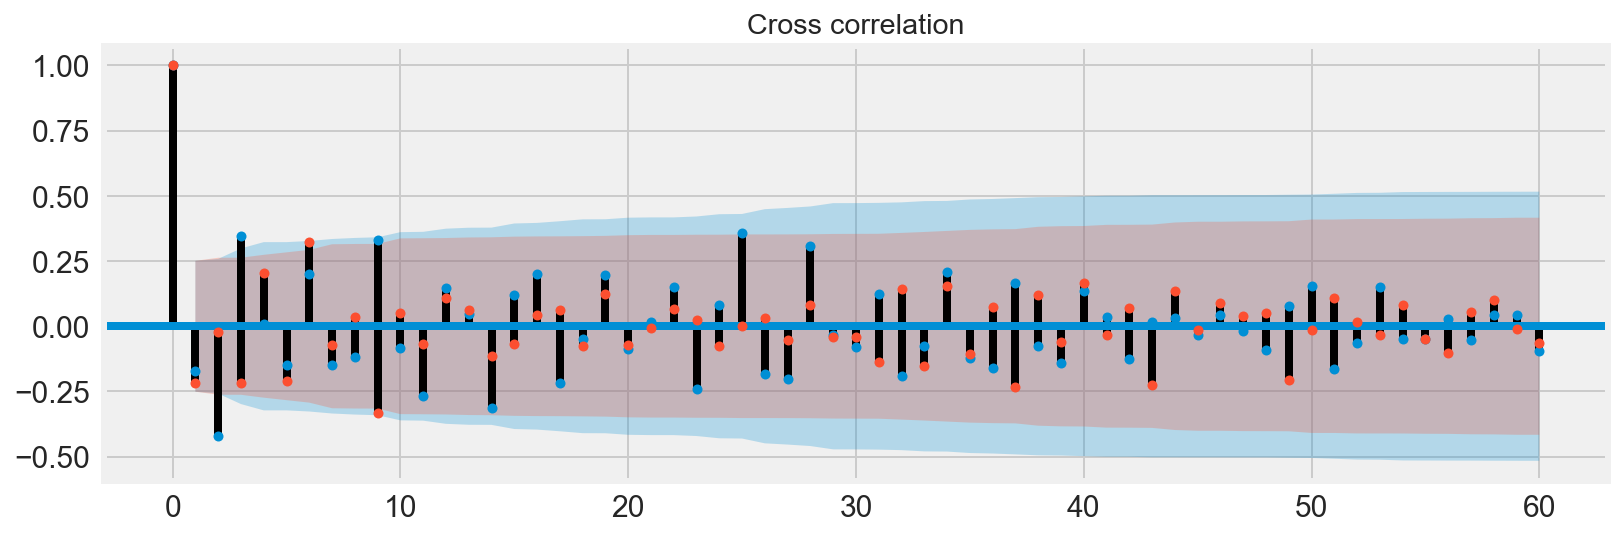

In [24]:
fig, ax = plt.subplots(figsize=(12,4))
plot_acf(ccf(results.resid['CPI'],results.resid['IP']),ax=ax)
plot_acf(ccf(results.resid['IP'],results.resid['CPI']),ax=ax)
ax.set_title('Cross correlation')
plt.show()

In [25]:
# forecasting
start_p = 20
forecast_end = 20
data = df_1[1:]
forecast_times = pd.date_range(str(data.index[len(data)-start_p]), periods=start_p+forecast_end, freq='A')
preds = results.predict(start=1,end=len(data)-1,dynamic=False)
forecast_times = pd.date_range(str(data.index[len(data)-start_p]), periods=start_p+forecast_end, freq='A')
preds_dyn = results.predict(start=data.index[len(data)-start_p],end=len(data)+forecast_end-1,dynamic=True)
preds_dyn.set_index(forecast_times,inplace=True)

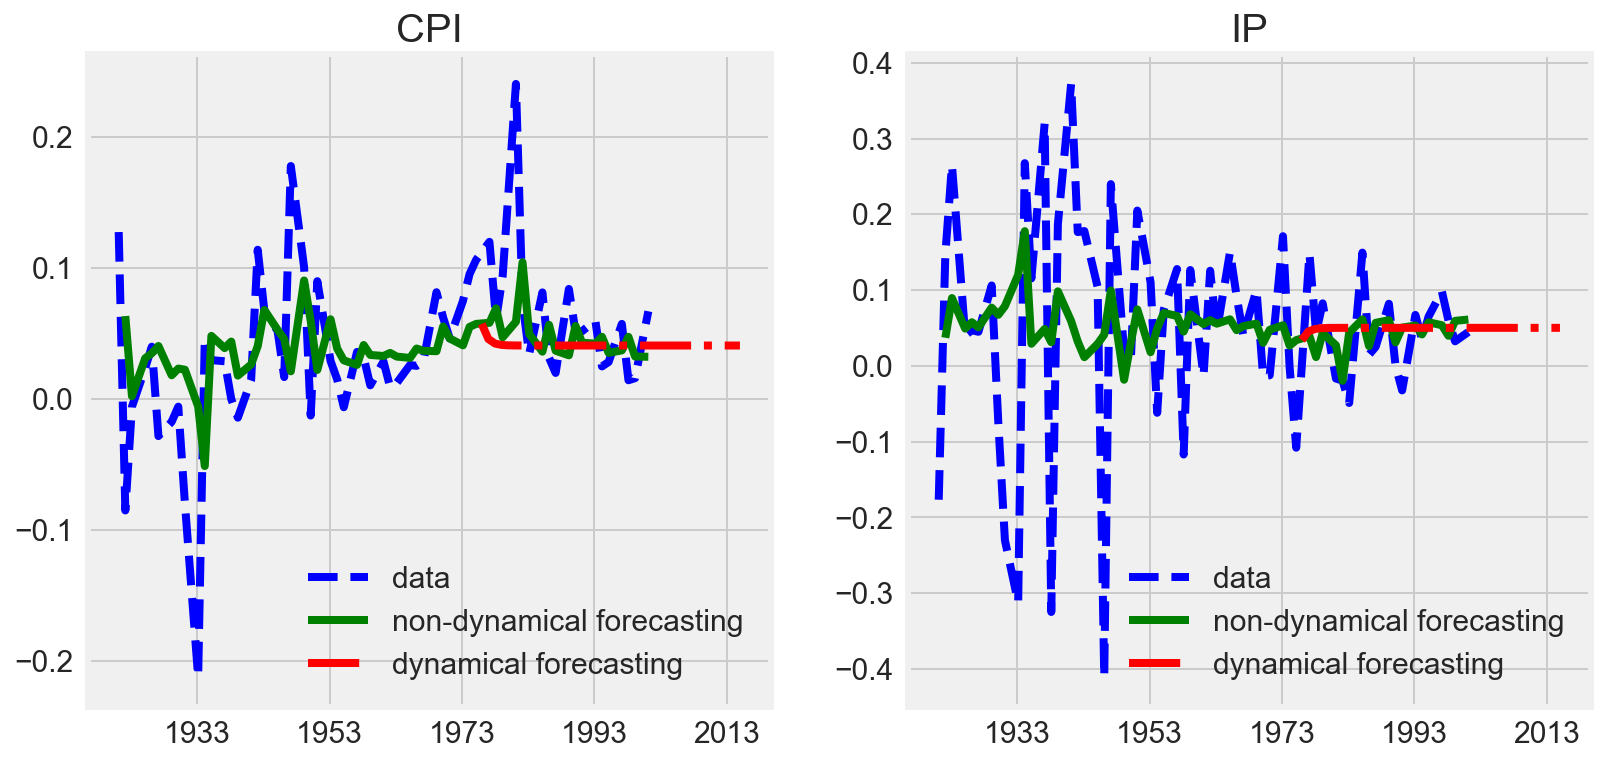

In [26]:
fig, ax = plt.subplots(ncols=2,figsize=(12,6))
ax[0].plot(data.CPI, 'b--' , preds.CPI, 'g-', preds_dyn.CPI,'r-.')
ax[0].legend(['data','non-dynamical forecasting','dynamical forecasting'],loc='lower right')
ax[0].set_title('CPI',fontsize=20)
ax[1].plot(data.IP, 'b--' , preds.IP, 'g-', preds_dyn.IP,'r-.')
ax[1].legend(['data','non-dynamical forecasting','dynamical forecasting'],loc='lower right')
ax[1].set_title('IP',fontsize=20)
plt.show()

In [27]:
np.sqrt((np.square(results.resid)).mean(axis=0))

CPI    0.057959
IP     0.138996
dtype: float64

In [28]:
1-np.sqrt((np.square(results.resid)).mean(axis=0))/df_1.std().values

CPI    0.062490
IP     0.025059
dtype: float64

## Resources
---

- [Statsmodels documentation](https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.varmax.VARMAX.html)
- [Statsmodels example](http://www.statsmodels.org/dev/examples/notebooks/generated/statespace_varmax.html)

> The book where these examples are from:

> *David Ruppert and David Matteson: Statistics and Data Analysis for financial engineering, Springer 2015.*
